In [2]:
from utils import *

In [2]:
boxes = [generate_box(0, 1000) for i in range(100)]
boxes[:10]

[array([[155, 155, 413, 413, 155, 155, 413, 413],
        [612,  50,  50, 612, 612,  50,  50, 612],
        [362, 362, 362, 362, 492, 492, 492, 492]]),
 array([[918, 918, 519, 519, 918, 918, 519, 519],
        [828, 746, 746, 828, 828, 746, 746, 828],
        [772, 772, 772, 772, 895, 895, 895, 895]]),
 array([[ 75,  75, 454, 454,  75,  75, 454, 454],
        [ 11, 278, 278,  11,  11, 278, 278,  11],
        [ 59,  59,  59,  59, 972, 972, 972, 972]]),
 array([[574, 574, 440, 440, 574, 574, 440, 440],
        [550, 966, 966, 550, 550, 966, 966, 550],
        [593, 593, 593, 593,  83,  83,  83,  83]]),
 array([[992, 992, 819, 819, 992, 992, 819, 819],
        [471, 573, 573, 471, 471, 573, 573, 471],
        [783, 783, 783, 783,  91,  91,  91,  91]]),
 array([[268, 268, 436, 436, 268, 268, 436, 436],
        [804, 912, 912, 804, 804, 912, 912, 804],
        [568, 568, 568, 568, 129, 129, 129, 129]]),
 array([[325, 325,  44,  44, 325, 325,  44,  44],
        [726, 791, 791, 726, 726, 791,

In [11]:
# Setup API
import requests
from requests.compat import urljoin
import json
from time import perf_counter

In [4]:
api_host = "http://localhost"
boxes_endpoint = "boxes/"

boxes_url = urljoin(api_host, boxes_endpoint)
response = requests.get(url=boxes_url)
response.json()[:1]

[{'x_min': 159.0,
  'x_max': 414.0,
  'y_min': 171.0,
  'y_max': 374.0,
  'z_min': 64.0,
  'z_max': 64.0,
  'id': '71a6466e-4b28-48ca-8af1-e5662d2bdb21'}]

In [23]:

for box in boxes:
    data = {
        "x_min": min(box[0]),
        "x_max": max(box[0]),
        "y_min": min(box[1]),
        "y_max": max(box[1]),
        "z_min": min(box[2]),
        "z_max": max(box[2]),
    }
    for key, value in data.items():
        data[key] = int(value)
    print(data)
    response = requests.post(urljoin(api_host, boxes_endpoint), json=data)
    assert response.status_code == 200, response.json()

{'x_min': 155, 'x_max': 413, 'y_min': 50, 'y_max': 612, 'z_min': 362, 'z_max': 492}
{'x_min': 519, 'x_max': 918, 'y_min': 746, 'y_max': 828, 'z_min': 772, 'z_max': 895}
{'x_min': 75, 'x_max': 454, 'y_min': 11, 'y_max': 278, 'z_min': 59, 'z_max': 972}
{'x_min': 440, 'x_max': 574, 'y_min': 550, 'y_max': 966, 'z_min': 83, 'z_max': 593}
{'x_min': 819, 'x_max': 992, 'y_min': 471, 'y_max': 573, 'z_min': 91, 'z_max': 783}
{'x_min': 268, 'x_max': 436, 'y_min': 804, 'y_max': 912, 'z_min': 129, 'z_max': 568}
{'x_min': 44, 'x_max': 325, 'y_min': 726, 'y_max': 791, 'z_min': 40, 'z_max': 835}
{'x_min': 566, 'x_max': 880, 'y_min': 23, 'y_max': 189, 'z_min': 465, 'z_max': 854}
{'x_min': 70, 'x_max': 833, 'y_min': 510, 'y_max': 808, 'z_min': 267, 'z_max': 615}
{'x_min': 84, 'x_max': 604, 'y_min': 469, 'y_max': 564, 'z_min': 73, 'z_max': 85}
{'x_min': 586, 'x_max': 887, 'y_min': 56, 'y_max': 877, 'z_min': 165, 'z_max': 750}
{'x_min': 162, 'x_max': 650, 'y_min': 610, 'y_max': 924, 'z_min': 529, 'z_max':

In [8]:
def show_3d_boxes(boxes):
    fig = go.Figure()

    for box in boxes:
        add_mesh_3d(fig, box)

    fig.update_layout(
        scene = {
            "xaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
            "yaxis": {
                "nticks": 4, 
                "range": [0, 1000],
            },
            "zaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
        },
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))

    fig.show()

In [17]:
response = requests.get(f"{boxes_url}?x=20&y=500")

In [6]:
from typing import Dict, Any

def convert_box_json_to_nparray(box_obj: Dict[str, Any]):
    del box_obj["id"]
    box_array = get_box_points_array(
        **box_obj
    )
    return box_array

convert_box_json_to_nparray(response.json()[0])

array([[ 23.,  23., 798., 798.,  23.,  23., 798., 798.],
       [145., 856., 856., 145., 145., 856., 856., 145.],
       [150., 150., 150., 150., 244., 244., 244., 244.]])

In [19]:
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
response_boxes[:2]

[array([[  4.,   4.,  99.,  99.,   4.,   4.,  99.,  99.],
        [222., 688., 688., 222., 222., 688., 688., 222.],
        [111., 111., 111., 111., 111., 111., 111., 111.]]),
 array([[ 19.,  19., 324., 324.,  19.,  19., 324., 324.],
        [144., 816., 816., 144., 144., 816., 816., 144.],
        [218., 218., 218., 218., 218., 218., 218., 218.]])]

Response Time: 0.02062823199958075
Showing 5 Boxes


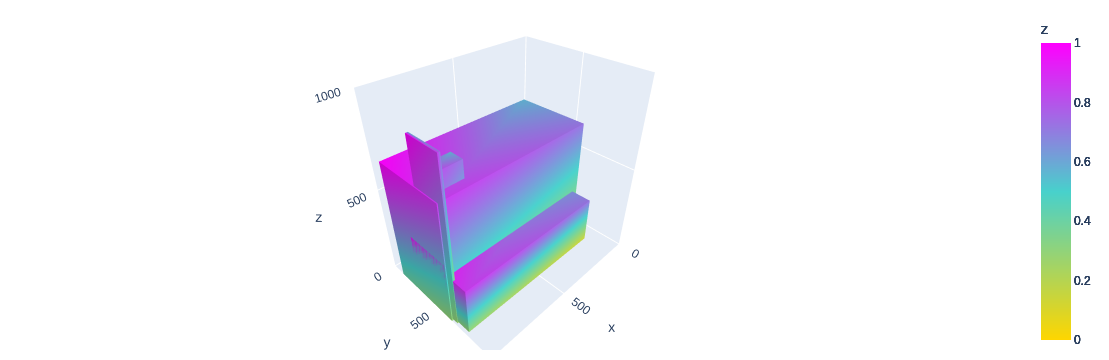

In [19]:
start = perf_counter()
response = requests.get(f"{boxes_url}?x=990&y=500&z=100")
end = perf_counter()
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
print(f"Response Time: {end - start}")
print(f"Showing {len(response_boxes)} Boxes")
show_3d_boxes(response_boxes)